In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from IPython import display

import matplotlib.pyplot as plt

In [525]:
dd = display.display

# 1. Gather

In [526]:
def loadData():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    
    return df

df_before_clean = loadData()
dd(df_before_clean)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008
5,796,566,320,NaN,1,1Fam,TA,No,732.0,0.0,...,WD,0,Pave,5,796.0,AllPub,40,1993,1995,2009
6,1694,0,0,NaN,3,1Fam,TA,Av,1369.0,0.0,...,WD,0,Pave,7,1686.0,AllPub,255,2004,2005,2007
7,1107,983,0,NaN,3,1Fam,TA,Mn,859.0,32.0,...,WD,0,Pave,7,1107.0,AllPub,235,1973,1973,2009
8,1022,752,0,NaN,2,1Fam,TA,No,0.0,0.0,...,WD,0,Pave,8,952.0,AllPub,90,1931,1950,2008
9,1077,0,0,NaN,2,2fmCon,TA,No,851.0,0.0,...,WD,0,Pave,5,991.0,AllPub,0,1939,1950,2008


# 2. Assess Data : Inspecting Data for Quality and Tidiness Issues
#### 2.1 Quality Issues : Issues with content - missing, duplicate or incorrect data. a.k.a Dirty data 
* 2.1.a Completeness : *"Are there any rows, columns or cells missing values?"*
  * 35 columns have the missing values: 
  
  ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF', 'Utilities']
####   
* 2.1.b Validity : *"Does the data comply to the data schema like duplicate patient id or zip code being < 5 digits or float data type?"*
  * 
  * 
  
####   
  
* 2.1.c Accuracy : *"Wrong data that is valid. like hieght = 300 inches; it still complies to the standard i.e. inches but data is in accurate."*
  * 
####   
  
* 2.1.d Consistency : *"Both valid and accurate but inconsistent. state = california and CA"*
  * 
####    


#### 2.2 Tidiness Issues: Issues with structure - untidy or messy data
* 2.2.a Each observation is a row
  * Yes: Each observation is a unique house (no duplicate records)
######   
* 2.2.b Each variable is a column
  * 
  * 
  * 
  * 
######  
* 2.2.c Each observational unit is a table
  * 
######   

### 2.1.a Completeness : *"Are there any rows, columns or cells missing values?"*

In [524]:
def missingValueAssessment(df):
    nan_columns = df.columns[df.isna().any()].tolist()
    print('NaN columns :', nan_columns, "\n# :", len(nan_columns))
missingValueAssessment(df_before_clean)

NaN columns : ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF', 'Utilities'] 
# : 35


### 2.2.a Each observation is a row

In [545]:
def checkHouseIsRepeated(df):
    df_temp = df.groupby(['SalePrice','GrLivArea','YearBuilt','YearRemodAdd']).agg('count').reset_index()[['SalePrice','GrLivArea','YearBuilt','YearRemodAdd','Id']]
    dd("Samples with same 'SalePrice','GrLivArea','YearBuilt','YearRemodAdd' : ",df_temp[df_temp.Id > 1])
    
    
checkHouseIsRepeated(df_before_clean)

"Samples with same 'SalePrice','GrLivArea','YearBuilt','YearRemodAdd' : "

,SalePrice,GrLivArea,YearBuilt,YearRemodAdd,Id


* As there are no time series data: as in there is no variable indicating the time of the reading carried out, It is safe to assume the reading was done at one shot and there would not be any duplicate entries of a house.
* With the above assumption, group by 'SalePrice','GrLivArea','YearBuilt','YearRemodAdd' count indicates that there are no duplicate records.

for c in df.fillna('NotAvailable')[nan_columns]:
    df[[c,'SalePrice']].fillna('NotAvailable').\
    groupby(by=c).agg('count').\
    plot.bar(legend=None, title="Frequency Plot for "+c)
    plt.xticks(rotation=45)
    plt.show()

In [115]:
def miscWrangling():
    df = pd.read_csv('train.csv')
    print("Count of missing MiscFeature : ",df[df.MiscFeature.isna()].shape)
    
miscWrangling()
    

Count of missing MiscFeature :  (1406, 81)


##### There is 'Other' and 'None' in the valid values list. so it would be difficult to find the related feature variables. Therefore, let us keep it simple (NA)

In [114]:
def fenceWrangling():
    df = pd.read_csv('train.csv')
    print("Count of missing Fence : ",df[df.Fence.isna()].shape)
    
    df['Fence'] = df.Fence.fillna('NA')
    #display.display(df[['Neighborhood','Fence', 'Id']].groupby(['Neighborhood','Fence']).agg('count'))
    display.display(df[['Fence','LotArea']].groupby(['Fence']).agg('mean').reset_index())
    display.display(df[['Fence','LotFrontage']].groupby(['Fence']).agg('median').reset_index())
    display.display(df[['Fence','1stFlrSF']].groupby(['Fence']).agg(lambda x: x.value_counts().index[0]).reset_index())
    
    
    
fenceWrangling()

Count of missing Fence :  (1179, 81)


,Fence,LotArea
0,GdPrv,10520.288136
1,GdWo,9634.018519
2,MnPrv,9204.458599
3,MnWw,9250.909091
4,NA,10743.659881


,Fence,LotFrontage
0,GdPrv,71.5
1,GdWo,71.0
2,MnPrv,70.0
3,MnWw,69.0
4,NA,68.0


,Fence,1stFlrSF
0,GdPrv,912
1,GdWo,864
2,MnPrv,894
3,MnWw,1134
4,NA,864


##### It is too risky to map from othe rvariables. Though it seems like it depends on LotArea or LotFrontage. It is not very clear if it depends solely on one of the variable or sort of combination of others. Let us keep it NA for missing values, so that it would mean no fence available.

In [100]:
def poolWrangling():
    df = pd.read_csv('train.csv')
    print("Count of missing PoolQC : ",df[df.PoolQC.isna()].shape)
    
    display.display(df[df.PoolQC.isna()][['PoolArea', 'PoolQC']].head())
    display.display(df[df.PoolQC.isna()][['PoolArea', 'PoolQC']].shape)
    display.display(df[df.PoolArea == 0][['PoolArea', 'PoolQC']].shape)
    
poolWrangling()

Count of missing PoolQC :  (1453, 81)


,PoolArea,PoolQC
0,0,NaN
1,0,NaN
2,0,NaN
3,0,NaN
4,0,NaN


(1453, 2)

(1453, 2)

##### When PoolArea is 0 PoolQC will be NA (no pool)

In [96]:
def GarageTypeWrangling():
    df = pd.read_csv('train.csv')
    print("Count of missing GarageType : ",df[df.GarageType.isna()].shape)
    
    Garage_columns = [x for x in list(df) if 'Garage' in x]
    print (Garage_columns)
    
    display.display(df[Garage_columns][df.GarageArea == 0].head())
    display.display(df[Garage_columns][df.GarageArea == 0].shape)
    
GarageTypeWrangling()

Count of missing GarageType :  (81, 81)
['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']


,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,NaN,NaN,NaN,0,0,NaN,NaN
48,NaN,NaN,NaN,0,0,NaN,NaN
78,NaN,NaN,NaN,0,0,NaN,NaN
88,NaN,NaN,NaN,0,0,NaN,NaN
89,NaN,NaN,NaN,0,0,NaN,NaN


(81, 7)

##### 'GarageType', 'GarageYrBlt', 'GarageFinish',  'GarageQual', 'GarageCond' will be marked as 'NA' for the missing entry when GarageArea == 0

In [91]:
def FireplaceWrangling():
    df = pd.read_csv('train.csv')
    print("Count of missing FireplaceQu : ",df[df.FireplaceQu.isna()].shape)
    display.display(df[['Fireplaces', 'FireplaceQu']][df.FireplaceQu.isna()].head())
    display.display(df[['Fireplaces', 'FireplaceQu']][df.FireplaceQu.isna()].shape)
FireplaceWrangling()

Count of missing FireplaceQu :  (690, 81)


,Fireplaces,FireplaceQu
0,0,NaN
5,0,NaN
10,0,NaN
12,0,NaN
15,0,NaN


(690, 2)

##### FireplaceQu will be mapped to NA (no fireplace) whenever Fireplaces = 0

In [86]:
def electricalWrangling():
    df = pd.read_csv('train.csv')
    print(df[df.Electrical.isna()].shape)
    df['Electrical'] = df.Electrical.fillna('NA')
    display.display(df[['Neighborhood','Electrical', 'Id']].groupby(['Neighborhood','Electrical']).agg('count'))
    
electricalWrangling()

(1, 81)


Id
Neighborhood Electrical     
Blmngtn      SBrkr        17
Blueste      SBrkr         2
BrDale       SBrkr        16
BrkSide      FuseA        13
             FuseF         3
             SBrkr        42
ClearCr      FuseA         2
             FuseF         1
             SBrkr        25
CollgCr      SBrkr       150
Crawfor      FuseA         3
             FuseF         2
             SBrkr        46
Edwards      FuseA        12
             FuseF         9
             FuseP         1
             SBrkr        78
Gilbert      SBrkr        79
IDOTRR       FuseA        10
             FuseF         4
             Mix           1
             SBrkr        22
MeadowV      SBrkr        17
Mitchel      FuseA         1
             SBrkr        48
NAmes        FuseA        27
             FuseF         3
             SBrkr       195
NPkVill      SBrkr         9
NWAmes       SBrkr        73
NoRidge      SBrkr        41
NridgHt      SBrkr        77
OldTown      FuseA        21
             FuseF         3
             FuseP         2
             SBrkr        87
SWISU        FuseA         3
             FuseF         2
             SBrkr        20
Sawyer       SBrkr        74
SawyerW      FuseA         1
             SBrkr        58
Somerst      SBrkr        86
StoneBr      SBrkr        25
Timber       FuseA         1
             NA            1
             SBrkr        36
Veenker      SBrkr        11

##### At Timber, most of them have SBrkr as electrical system. So, it is a safe bet to have the missing entry replaced with 'SBrkr'

(259, 81)
{'Blmngtn': 43.0, 'Blueste': 24.0, 'BrDale': 21.0, 'BrkSide': 50.0, 'ClearCr': 80.0, 'CollgCr': 65.0, 'Crawfor': 80.0, 'Edwards': 60.0, 'Gilbert': 65.0, 'IDOTRR': 60.0, 'MeadowV': 21.0, 'Mitchel': 100.0, 'NAmes': 70.0, 'NPkVill': 24.0, 'NWAmes': 80.0, 'NoRidge': 82.0, 'NridgHt': 107.0, 'OldTown': 60.0, 'SWISU': 60.0, 'Sawyer': 70.0, 'SawyerW': 65.0, 'Somerst': 75.0, 'StoneBr': 41.0, 'Timber': 85.0, 'Veenker': 80.0}
(0, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1127,1128,20,RL,182.0,14572,Pave,NaN,IR3,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,WD,Family,259000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


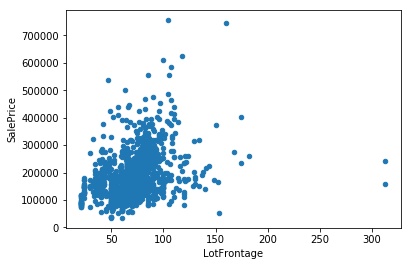

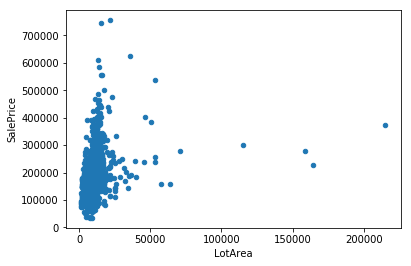

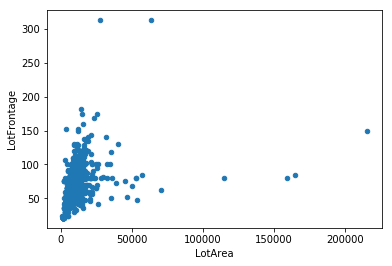

In [123]:
def LotFrontagecheck():
    df = pd.read_csv('train.csv')
    print(df[df.LotFrontage.isna()].shape)
    df_LotFrontage = df[['Neighborhood','LotFrontage']].groupby('Neighborhood').agg(lambda x:x.value_counts().index[0]).reset_index()
    df_dict = dict([tuple(x) for x in df_LotFrontage.values])
    print(df_dict)
    
    df['LotFrontage'] =df.LotFrontage.fillna(-1)
    df['LotFrontage'] =df.apply(lambda x: df_dict[x['Neighborhood']] if x['LotFrontage'] == -1 else x['LotFrontage'],axis=1)
    print(df[df.LotFrontage.isna()].shape)
    
    df.plot.scatter('LotFrontage', 'SalePrice')
    df.plot.scatter('LotArea', 'SalePrice')
    df.plot.scatter('LotArea', 'LotFrontage')
    
    display.display(df[df.LotFrontage > 175])
   # df.
    
LotFrontagecheck() 

##### LotFrontage: taking neighborhood as reference most occuring distance is used for filling missing values. Inspiration: neighboring house have same distance to road /gate.

* Lot area > 10000 & LotFrontage > 200  seems like outliers

In [75]:
def MasVnrTypeCheck():
    df = pd.read_csv('train.csv')
    print(df[df.MasVnrType.isna()].shape, )
    #display.display(df[['Neighborhood','MasVnrType','Id']].groupby(['Neighborhood','MasVnrType']).agg('count').reset_index())
    
    display.display(df[['MasVnrType','MasVnrArea']][df.MasVnrType.isna()])
MasVnrTypeCheck()

(8, 81)


,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


##### MasVnrType will be set to None for missing entries because corresponding area is not available

(8, 81)


,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


,MasVnrType,MasVnrArea
1,None,0.0
3,None,0.0
5,None,0.0
8,None,0.0
9,None,0.0


(861, 2)


,OverallCond,OverallQual
297,5,7


(247, 81)

,MasVnrArea,SalePrice
MasVnrArea,1.000000,0.484942
SalePrice,0.484942,1.000000


,MasVnrArea,SalePrice
MasVnrArea,1.000000,0.477493
SalePrice,0.477493,1.000000


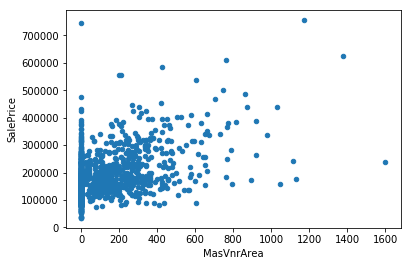

In [148]:
def MasVnrAreaWrangling():
    df = pd.read_csv('train.csv')
    print(df[df.MasVnrArea.isna()].shape)
    display.display(df[['MasVnrType','MasVnrArea']][df.MasVnrArea.isna()])
    display.display(df[['MasVnrType','MasVnrArea']][df.MasVnrArea ==0].head())
    print(df[['MasVnrType','MasVnrArea']][df.MasVnrArea ==0].shape)
    
    df.plot.scatter('MasVnrArea','SalePrice')
    
    display.display(df[df.MasVnrArea > 1400][['OverallCond','OverallQual']])
    
    display.display(df[(df.OverallCond == 5) & (df.OverallQual == 7)].shape)
    
    display.display(df[df.MasVnrArea < 1400][['MasVnrArea','SalePrice']].corr())
    display.display(df[['MasVnrArea','SalePrice']].corr())
    
    
MasVnrAreaWrangling()

* MasVnrArea nan count is equivalent to MasVnrType count.
* MasVnrArea == 0 is already present 
* whenever MasVnrArea == 0 MasVnrType is also None 
* Therefore, MasVnrArea will be mapped to zero when MasVnrType = None

##### Outlier: area > 1400 is only one sample which has low sale price. Its overall condition and quality is moderate and there are enough sample for those bands.

(37, 81)
['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']


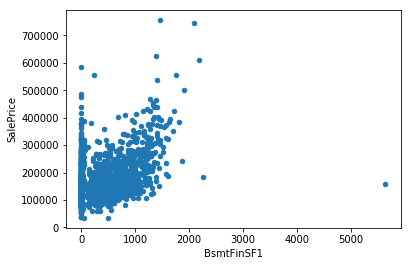

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
39,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
90,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
102,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
156,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
182,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
259,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
342,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
362,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
371,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
523,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,1,0
1298,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,2,0


,OverallCond,OverallQual
523,5,10
1298,5,10


(15, 81)

,BsmtFinSF1,SalePrice
BsmtFinSF1,1.00000,0.38642
SalePrice,0.38642,1.00000


,BsmtFinSF1,SalePrice
BsmtFinSF1,1.000000,0.409384
SalePrice,0.409384,1.000000


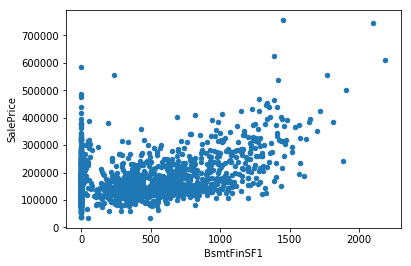

In [145]:
def bsmtWrangling():
    df = pd.read_csv('train.csv')
    print(df[df.BsmtQual.isna()].shape)
    bsmt_columns = [x for x in list(df) if 'Bsmt' in x]
    print (bsmt_columns)
    df.plot.scatter('BsmtFinSF1','SalePrice')
    plt.show()
    display.display(df[bsmt_columns][df.BsmtQual.isna()])
    
    df[(df.BsmtFinSF1 < 2000) | (df.SalePrice > 200000)].plot.scatter('BsmtFinSF1','SalePrice')
    display.display(df[(df.BsmtFinSF1 > 2000) & (df.SalePrice < 200000)][bsmt_columns])
    display.display(df[(df.BsmtFinSF1 > 2000) & (df.SalePrice < 200000)][['OverallCond','OverallQual']])
    display.display(df[(df.OverallCond == 5) & (df.OverallQual == 10)].shape)
    
    display.display(df[['BsmtFinSF1','SalePrice']].corr())
    display.display(df[['BsmtFinSF1','SalePrice']][(df.BsmtFinSF1 < 2000) | (df.SalePrice > 200000)].corr())

bsmtWrangling()

##### TotalBsmtSF = 0 indicates there is no basement. 
* Therefore, BsmtQual = BsmtCond = BsmtExposure = BsmtFinType1 = BsmtFinType2 = "NA"; when TotalBsmtSF = 0 

* Outlier: (df.BsmtFinSF1 > 2000) & (df.SalePrice < 200000) (2 of them) are outlier because it not only brings the co relation down but also there are enough samples for outlier's overall condition and quality samples.

In [11]:
print("GarageYrBlt : \nmean : ", df.GarageYrBlt.mean(),  "\nmedian : ",df.GarageYrBlt.median(), "\nmode : ", df.GarageYrBlt.mode()) 

GarageYrBlt : 
mean :  1978.5061638868744 
median :  1980.0 
mode :  0    2005.0
dtype: float64


In [12]:
df[df.GarageYrBlt.isna()].shape

(81, 81)

In [13]:
df[['GarageYrBlt','SalePrice']].groupby(['GarageYrBlt']).\
    agg('count').reset_index().rename(index=str,columns={'SalePrice':'Count'}).\
    sort_values(by='Count',ascending=False).head()

,GarageYrBlt,Count
91,2005.0,65
92,2006.0,59
90,2004.0,53
89,2003.0,50
93,2007.0,49


##### It is too risky to put mode as a imputing value.

In [14]:
df_temp = df.copy()
df_temp['GarageYrBlt'] = df.GarageYrBlt.interpolate('nearest')
df_temp[['GarageYrBlt','SalePrice']].groupby(['GarageYrBlt']).\
    agg('count').reset_index().rename(index=str,columns={'SalePrice':'Count'}).\
    sort_values(by='Count',ascending=False).head()

,GarageYrBlt,Count
91,2005.0,68
92,2006.0,64
90,2004.0,57
89,2003.0,52
93,2007.0,51


In [15]:
df_temp[df.GarageYrBlt.isna()][['GarageYrBlt','YearBuilt']]

,GarageYrBlt,YearBuilt
39,1953.0,1955
48,2006.0,1920
78,1948.0,1968
88,2009.0,1915
89,1950.0,1994
99,1920.0,1959
108,1948.0,1919
125,1979.0,1935
127,1977.0,1930
140,1997.0,1971


##### It cant be true that GarageYrBlt < YearBuilt. Can we see the patter between these two columns when they are present

In [16]:
df[df.GarageYrBlt == df.YearBuilt].shape

(1089, 81)

In [17]:
df[df.GarageYrBlt.isna()].shape

(81, 81)

In [18]:
df.shape

(1460, 81)

* There are 3 options for us :
  * populate garage year built as 0 : Zero is a invalid data, it would not follow the "validity" of the data format. i.e. there is no year with 0. Hence, this option is cancelled.
  * populate garage built year = house built year: This is a misinterpretation of the data as we clearly know that there is no garage and it cannot have yearbuilt value.
  * drop the variable
 
 ##### There are no houses which has garage built year but not type of the finish. This indicates that empty values are only because there is no garage. Should we drop this feature ? because we know that it does not matter for a house when garage was built. It is, however, important to know if the garage is present or not and how big it is if present. Moreover, we do not have the time series of data to support the hypothesis that the sale price got increased post garage is built.

In [19]:
df[df.GarageYrBlt < df.YearBuilt][['GarageYrBlt', 'YearBuilt']]

,GarageYrBlt,YearBuilt
29,1920.0,1927
93,1900.0,1910
324,1961.0,1967
600,2003.0,2005
736,1949.0,1950
1103,1954.0,1959
1376,1925.0,1930
1414,1922.0,1923
1418,1962.0,1963


##### May be in these houses they first used to part thier old car then started their construction. I guess for all practical purpose we may safely assume YearBuilt <= GarageYrBlt.

In [20]:
df[(df.GarageFinish.notna()) & (df.GarageYrBlt.isna()) ][['GarageYrBlt','YearBuilt','GarageType','GarageFinish','GarageCars', 'GarageArea']]

,GarageYrBlt,YearBuilt,GarageType,GarageFinish,GarageCars,GarageArea


In [21]:
df[df.GarageYrBlt.isna()][['GarageYrBlt','YearBuilt','GarageType','GarageFinish','GarageCars', 'GarageArea']]

,GarageYrBlt,YearBuilt,GarageType,GarageFinish,GarageCars,GarageArea
39,NaN,1955,NaN,NaN,0,0
48,NaN,1920,NaN,NaN,0,0
78,NaN,1968,NaN,NaN,0,0
88,NaN,1915,NaN,NaN,0,0
89,NaN,1994,NaN,NaN,0,0
99,NaN,1959,NaN,NaN,0,0
108,NaN,1919,NaN,NaN,0,0
125,NaN,1935,NaN,NaN,0,0
127,NaN,1930,NaN,NaN,0,0
140,NaN,1971,NaN,NaN,0,0


In [22]:
df = df.drop('GarageYrBlt',axis=1)

In [23]:
df = df.fillna('NotAvailable')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non

In [168]:
for c in list(df):
    print(df[c].describe())
    input("")

count    1460.000000
mean      730.500000
std       421.610009
min         1.000000
25%       365.750000
50%       730.500000
75%      1095.250000
max      1460.000000
Name: Id, dtype: float64

count    1460.000000
mean       56.897260
std        42.300571
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

count     1460
unique       5
top         RL
freq      1151
Name: MSZoning, dtype: object

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

count     1460
unique       2
top       Pave
freq      1454
Name: Street, dtype: object

count 


count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

count     1379
unique       3
top        Unf
freq       605
Name: GarageFinish, dtype: object

count    1460.000000
mean        1.767123
std         0.747315
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: GarageCars, dtype: float64

count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

count     1379
unique       5
top         TA
freq      1311
Name: GarageQual, dtype: object

count     1379
unique       5
top         TA
freq      1326
Name: GarageCond, dtype: object

count     1460
unique       3
top          Y
freq      1340
Name: PavedDrive, dtype: object

count    1460.0000

,1stFlrSF,SalePrice
1stFlrSF,1.000000,0.605852
SalePrice,0.605852,1.000000


,1stFlrSF,SalePrice
1stFlrSF,1.000000,0.625662
SalePrice,0.625662,1.000000


,TotalBsmtSF,SalePrice,OverallCond,OverallQual
1298,6110,160000,5,10


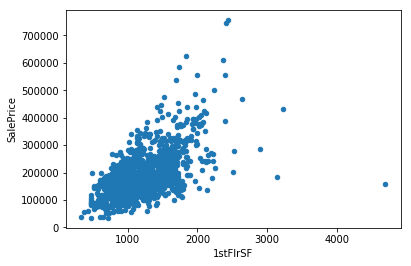

In [167]:
def firststFlrSFOutlierCheck():
    df = pd.read_csv('train.csv')
    df.plot.scatter('1stFlrSF', 'SalePrice')
    
    display.display(df[['1stFlrSF', 'SalePrice']].corr())
    display.display(df[['1stFlrSF', 'SalePrice']][df['1stFlrSF'] < 4000].corr())
    
    display.display(df[['TotalBsmtSF', 'SalePrice', 'OverallCond', 'OverallQual']][df['1stFlrSF'] > 4000])
    
firststFlrSFOutlierCheck()

##### 1stFlrSF > 4000 increases the co relation and there are enough samples for the overall cond and quality.

,TotalBsmtSF,SalePrice
TotalBsmtSF,1.000000,0.613581
SalePrice,0.613581,1.000000


,TotalBsmtSF,SalePrice
TotalBsmtSF,1.000000,0.645749
SalePrice,0.645749,1.000000


,TotalBsmtSF,SalePrice,OverallCond,OverallQual
1298,6110,160000,5,10


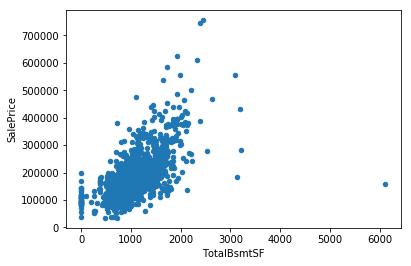

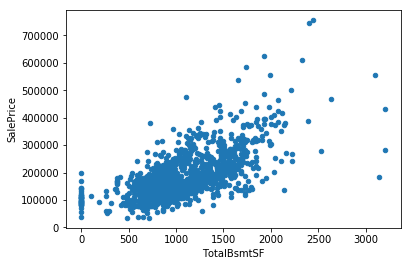

In [162]:
def TotalBsmtSFOutlierCheck():
    df = pd.read_csv('train.csv')
    #print(df[df.BsmtFinSF2.isna()].shape)
    
    df.plot.scatter('TotalBsmtSF', 'SalePrice')
    display.display(df[['TotalBsmtSF', 'SalePrice']].corr())
    display.display(df[['TotalBsmtSF', 'SalePrice']][df.TotalBsmtSF < 4000].corr())
    df[df.TotalBsmtSF < 4000].plot.scatter('TotalBsmtSF', 'SalePrice')
    
    display.display(df[['TotalBsmtSF', 'SalePrice', 'OverallCond', 'OverallQual']][df.TotalBsmtSF > 4000])
    
TotalBsmtSFOutlierCheck()

##### TotalBsmtSF > 4000 increases the co relation and there are enough samples for the overall cond and quality.

,BsmtUnfSF,SalePrice
BsmtUnfSF,1.000000,0.214479
SalePrice,0.214479,1.000000


,BsmtUnfSF,SalePrice
BsmtUnfSF,1.000000,0.220701
SalePrice,0.220701,1.000000


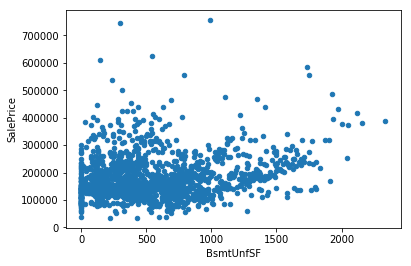

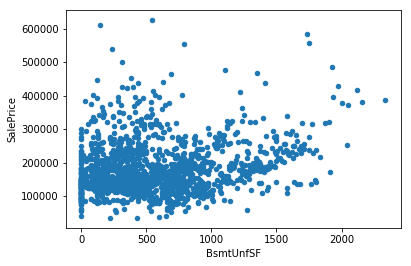

In [158]:
def BsmtUnfSFOutlierCheck():
    df = pd.read_csv('train.csv')
    #print(df[df.BsmtFinSF2.isna()].shape)
    
    df.plot.scatter('BsmtUnfSF', 'SalePrice')
    display.display(df[['BsmtUnfSF', 'SalePrice']].corr())
    display.display(df[['BsmtUnfSF', 'SalePrice']][df.SalePrice < 700000].corr())
    df[df.SalePrice < 700000].plot.scatter('BsmtUnfSF', 'SalePrice')
    
BsmtUnfSFOutlierCheck()

##### Co relation increases mildly and it involves chopping sale price as the outlier. Hence, there will not be any outlier removal from BsmtUnfSF

,BsmtFinSF2,SalePrice
BsmtFinSF2,1.000000,-0.011378
SalePrice,-0.011378,1.000000


,BsmtFinSF2,SalePrice
BsmtFinSF2,1.000000,-0.021143
SalePrice,-0.021143,1.000000


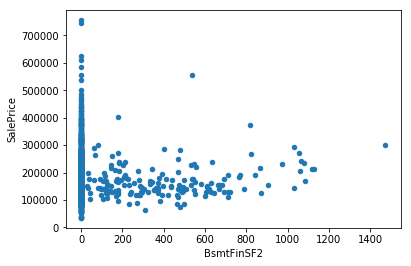

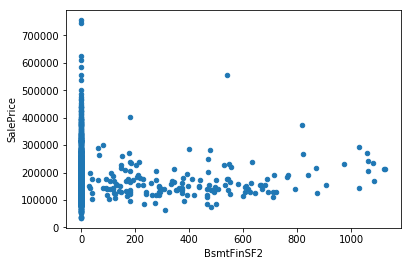

In [154]:
def BsmtFinSF2OutlierCheck():
    df = pd.read_csv('train.csv')
    #print(df[df.BsmtFinSF2.isna()].shape)
    
    df.plot.scatter('BsmtFinSF2', 'SalePrice')
    display.display(df[['BsmtFinSF2', 'SalePrice']].corr())
    display.display(df[['BsmtFinSF2', 'SalePrice']][df.BsmtFinSF2 < 1200].corr())
    df[df.BsmtFinSF2 < 1200].plot.scatter('BsmtFinSF2', 'SalePrice')
    
BsmtFinSF2OutlierCheck()

##### Would not matter much if we remove [df.BsmtFinSF2 > 1200] outlier. But we may opt to.

In [26]:
df[(df.LotArea <11602) & (df.LotArea > 11601)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


* Following are Categorical Variables but currently are being considered as integer/float:
  * MSSubClass
  * OverallQual
  * OverallCond
  * FireplaceQu
  * MoSold
  
* Following variables are supposed to be Integer type but Box-Cox or Scaling will anyway type cast them to float:
  * LotFrontage, LotArea, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, YrSold, SalePrice


##### Alley

In [30]:
df[['Neighborhood','Alley','Id']].groupby(['Neighborhood','Alley']).agg('count')

Id
Neighborhood Alley            
Blmngtn      NotAvailable   17
Blueste      NotAvailable    2
BrDale       NotAvailable   16
BrkSide      NotAvailable   53
             Pave            5
ClearCr      NotAvailable   28
CollgCr      NotAvailable  150
Crawfor      Grvl            1
             NotAvailable   50
Edwards      Grvl            6
             NotAvailable   94
Gilbert      NotAvailable   79
IDOTRR       Grvl            5
             NotAvailable   30
             Pave            2
MeadowV      NotAvailable   17
Mitchel      NotAvailable   49
NAmes        Grvl            1
             NotAvailable  224
NPkVill      NotAvailable    9
NWAmes       NotAvailable   73
NoRidge      NotAvailable   41
NridgHt      NotAvailable   77
OldTown      Grvl           36
             NotAvailable   70
             Pave            7
SWISU        Grvl            1
             NotAvailable   21
             Pave            3
Sawyer       NotAvailable   74
SawyerW      NotAvailable   59
Somerst      NotAvailable   62
             Pave           24
StoneBr      NotAvailable   25
Timber       NotAvailable   38
Veenker      NotAvailable   11

##### It is too risky to assume based to 'Neighborhood'. Safer to assume as None or NotAvailable

#### 2.2 Wrangling
* should we try to see all the outlier or only the ones which have high co relation with target variable ?
* have both test and train data for data missing and imputation activities and NOT for outlier removal.
* is there any way we can identify the outlier in categorical values ?

In [201]:
def checkCorr():
    df_old = pd.read_csv('train.csv')
    
    for c in ['MSSubClass', 'OverallQual', 'OverallCond', 'FireplaceQu', 'MoSold']:
        df_old[c] = df_old[c].astype(np.object)
    #df.info()
    df = pd.get_dummies(df_old)
    #df_corr = df.corr()
    #print(df_corr.max())
    
    #df_corr = df_corr.replace(1, -1)
    #print(df_corr.max())
    
    #df.OverallQual = df.OverallQual.astype(np.object)
    corr_target = []
    df_corr = df.corr()
    for c in list(df_corr):
        corr_target.append((c, np.abs(df_corr.loc[c,'SalePrice'])))
    #print(corr_target)
    display.display(
        [x for x in sorted(corr_target,key=lambda x: x[1], reverse=True) if '_' not in x[0]][1:15])
    #print([c for c in corr_target if "Over" in c[0]])
checkCorr()

[('GrLivArea', 0.7086244776126511),
 ('GarageCars', 0.640409197258349),
 ('GarageArea', 0.6234314389183598),
 ('TotalBsmtSF', 0.6135805515591944),
 ('1stFlrSF', 0.6058521846919166),
 ('FullBath', 0.5606637627484452),
 ('TotRmsAbvGrd', 0.5337231555820238),
 ('YearBuilt', 0.5228973328794967),
 ('YearRemodAdd', 0.5071009671113867),
 ('GarageYrBlt', 0.48636167748786213),
 ('MasVnrArea', 0.4774930470957107),
 ('Fireplaces', 0.4669288367515242),
 ('BsmtFinSF1', 0.38641980624215627),
 ('LotFrontage', 0.35179909657067854)]

##### Our outliers must be removed from above list if at all there are present. I believe, if they are present in other variables then it would not have such huge impact on the target variable prediction as they have low co relation value.

#### What are the missing values in both train and test data ?

(2919, 81)


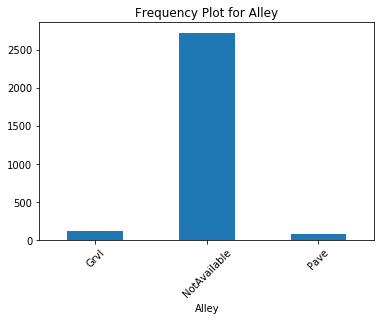

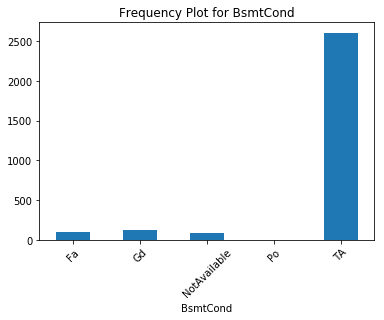

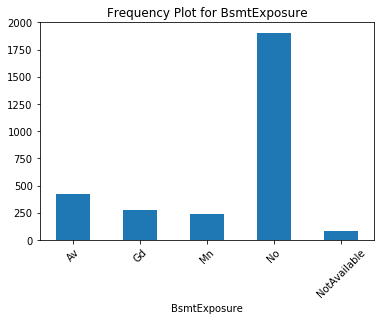

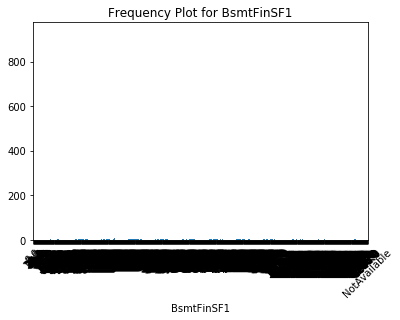

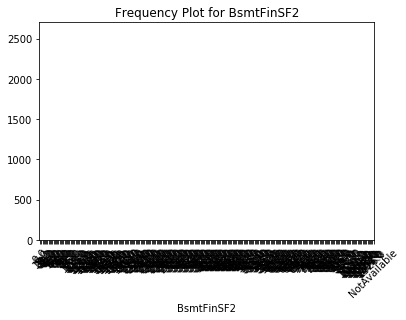

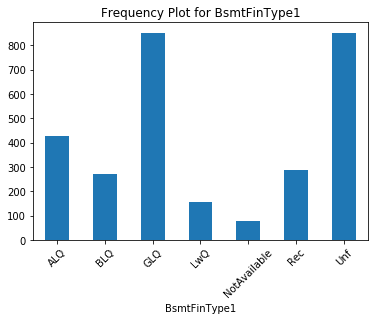

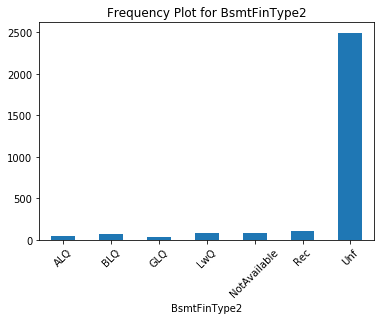

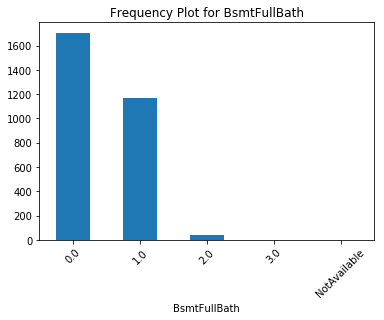

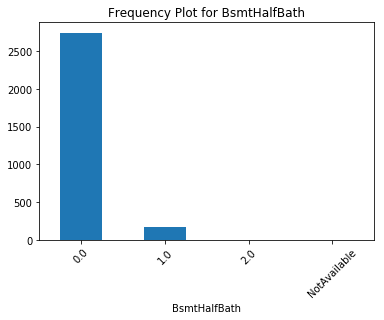

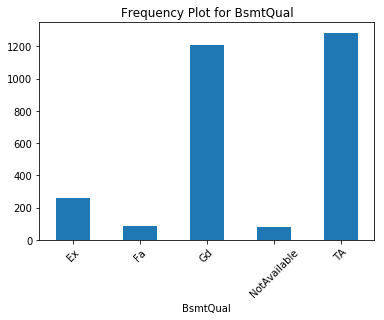

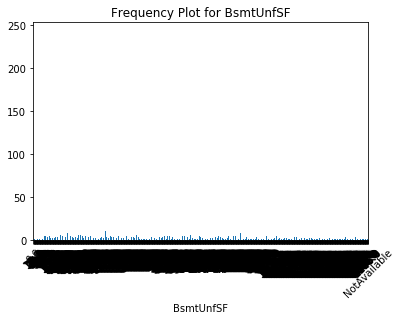

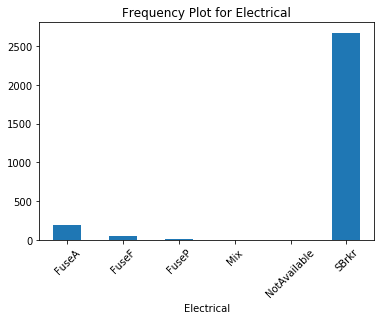

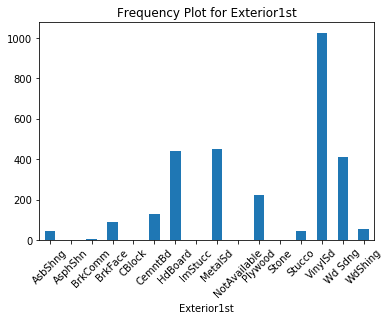

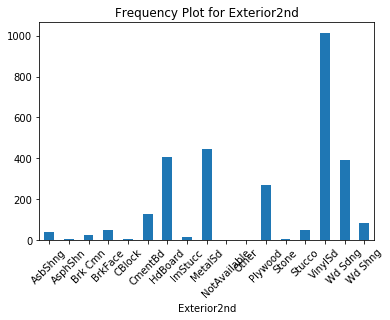

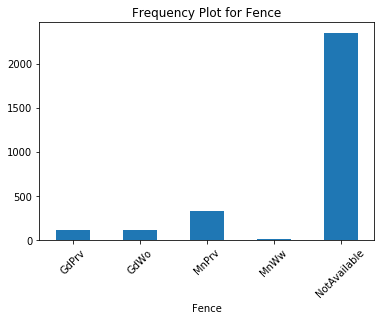

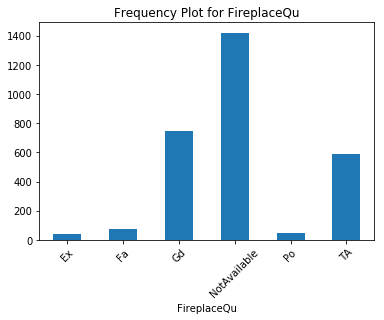

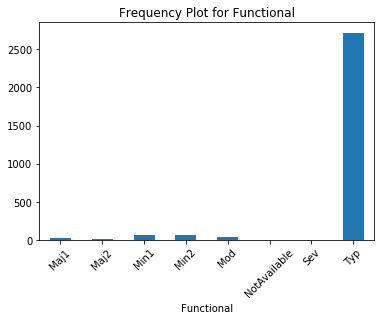

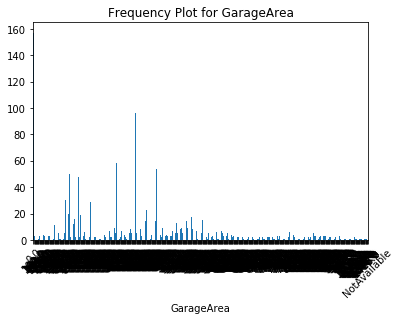

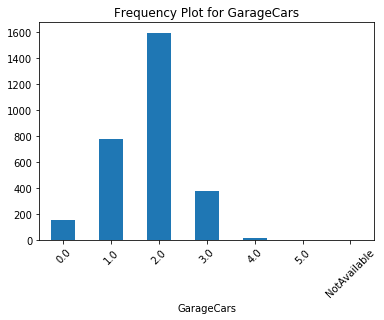

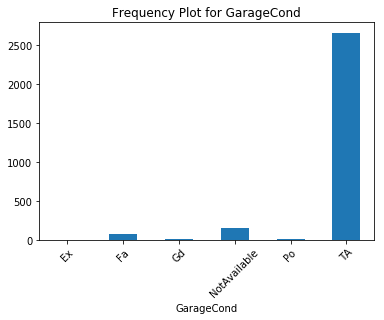

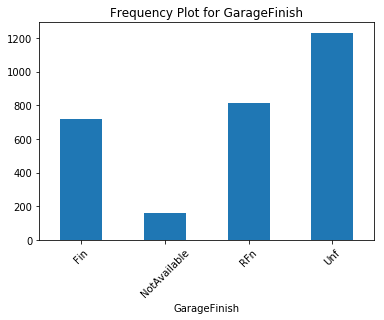

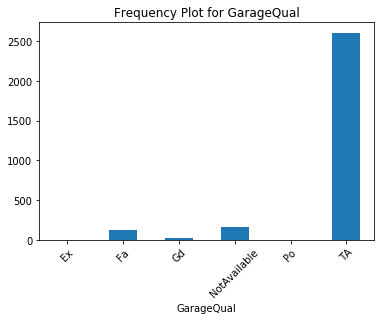

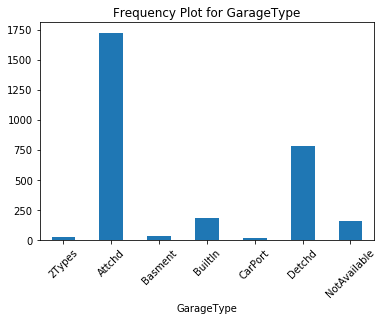

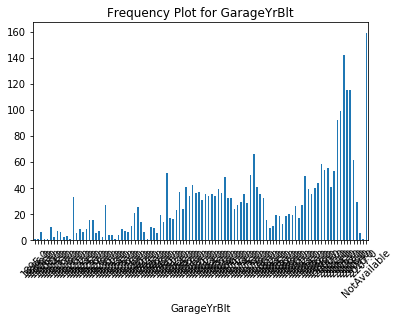

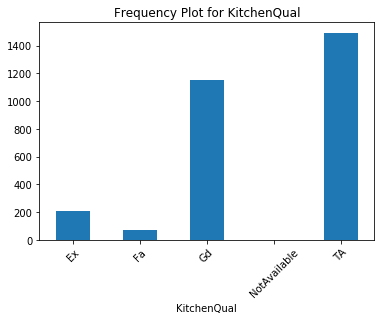

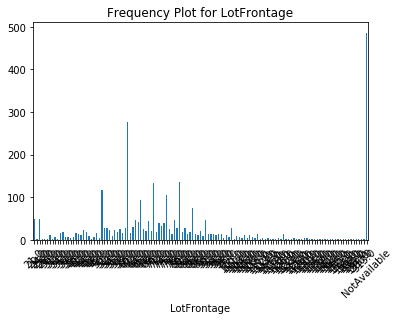

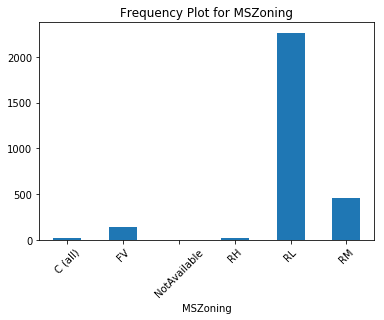

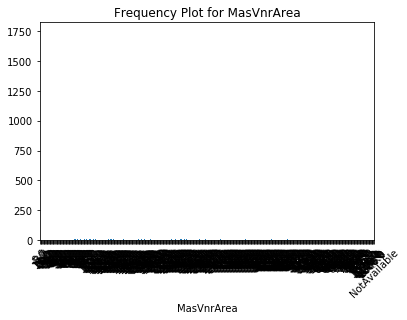

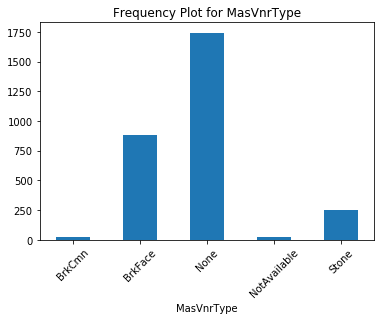

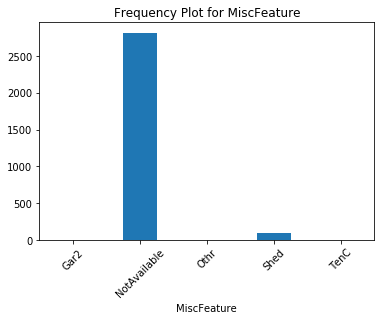

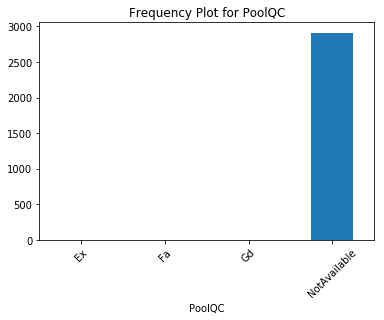

ValueError: Grouper for 'SalePrice' not 1-dimensional

In [217]:
def missingCheck():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True)
    print("Total dataset size : ", df.shape)
    
    nan_columns = df.columns[df.isna().any()].tolist()
    for c in df.fillna('NotAvailable')[nan_columns]:
        df[[c,'SalePrice']].fillna('NotAvailable').\
        groupby(by=c).agg('count').\
        plot.bar(legend=None, title="Frequency Plot for "+c)
        plt.xticks(rotation=45)
        plt.show()
    
missingCheck()


In [522]:
def poolQcWrangle():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    
    dd(df[df.PoolQC.isna()][['PoolQC','PoolArea']].head())
    df['PoolQC'] = df.apply(lambda x: 'NA' if x['PoolArea'] == 0 else x['PoolQC'], axis=1)
    dd(df[df.PoolQC.isna()][['PoolQC','PoolArea']]) 
    dd(df[(df.PoolQC.isna()) | (df.PoolQC == 'Fa' ) | (df.PoolQC == 'Gd' ) | (df.PoolQC == 'TA' )][['PoolQC','PoolArea', 'OverallCond', 'OverallQual']].sort_values(by='PoolQC'))
poolQcWrangle()

,PoolQC,PoolArea
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0


,PoolQC,PoolArea
2420,NaN,368
2503,NaN,444
2599,NaN,561


,PoolQC,PoolArea,OverallCond,OverallQual
810,Fa,648,6,6
1386,Fa,519,5,7
1170,Gd,576,6,6
1298,Gd,480,5,10
1423,Gd,738,7,6
2710,Gd,800,4,7
2420,NaN,368,6,4
2503,NaN,444,5,6
2599,NaN,561,5,3


* when PoolQC should be "NA" when PoolArea = 0 [Thumb rule / Common sense]
* Missing values have characterstics matching with that of "Fair" condition. It may be "TA" but we dont have enough evidence or rather no evidence for that.

In [508]:
def miscFeatureWrangle():
    
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    
    #dd(df[df.MiscFeature.isna()][['MiscFeature','MiscVal']].head())
    dd(df.fillna('NA').groupby(['MiscFeature','MiscVal']).agg('count').reset_index()[['MiscFeature','MiscVal','Id']])
miscFeatureWrangle()

,MiscFeature,MiscVal,Id
0,Gar2,3000,1
1,Gar2,4500,1
2,Gar2,8300,1
3,Gar2,12500,1
4,Gar2,15500,1
5,NA,0,2813
6,NA,17000,1
7,Othr,0,1
8,Othr,3000,1
9,Othr,3500,1


* When MiscVal == 0 ; MiscFeature is mostly NA (None). Note that it can be Shed or Other too. Will park it for next level fine tuning.
* High Values are dedicated to 'Gar2'. Therefore, testing set missing value is gar2 for sure.

In [501]:
def msZoningWrangle():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    
    zone_related = ['LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
                    'Condition2', 'BldgType', 'OverallQual', 'OverallCond', 'MSZoning'
                   ]
    
    dd(df[df.MSZoning.isna()][zone_related])
    #dd(df.groupby(['Neighborhood','MSSubClass','MSZoning']).agg('count').reset_index()[['Neighborhood','MSSubClass','MSZoning','Id']])
    dd(df[zone_related][(df.OverallCond.isin([1,2,5]) ) & (df.OverallQual.isin([4,5,1,3])) & (df.Neighborhood == 'IDOTRR')])
    temp  = df.groupby(['Neighborhood','MSZoning']).agg('count').reset_index()[['Neighborhood','MSZoning','Id']]
    dd(temp[(temp.Neighborhood == 'IDOTRR')  |(temp.Neighborhood == 'Mitchel')])
msZoningWrangle()    

,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,OverallQual,OverallCond,MSZoning
1915,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2,4,NaN
2216,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1,5,NaN
2250,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,5,1,NaN
2904,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1,3,NaN


,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,OverallQual,OverallCond,MSZoning
52,IR2,Bnk,AllPub,Corner,Mod,IDOTRR,RRNn,Norm,Duplex,5,5,RM
88,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,3,2,C (all)
121,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,4,5,RM
296,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,5,5,RM
329,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Norm,Norm,1Fam,5,5,RM
398,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Norm,Norm,1Fam,5,2,RM
495,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,4,5,C (all)
705,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,2fmCon,4,5,RM
729,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,4,5,RM
812,Reg,Bnk,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,5,5,C (all)


,Neighborhood,MSZoning,Id
16,IDOTRR,C (all),22
17,IDOTRR,RM,68
19,Mitchel,RL,104
20,Mitchel,RM,9


##### MSZoning is general zoning classification. Therefore,  it must be specific to an area and hence 'Neighborhood' is the variable to our rescue. MSZoning = RL  when neighbor is 'Mitchel' and  RM when neighbor is  IDOTRR and they are is missing.

In [474]:
def kitchenQual():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    
    co_qu_columns = [c for c in list(df) if ("Co" in c) or ("Qu" in c)]
    co_qu_columns += ['SalePrice','KitchenAbvGr']
    print(co_qu_columns)
    
    dd(df[df.KitchenQual.isna()][co_qu_columns])
    dd(df[(df.KitchenAbvGr == 1) & (df.OverallCond == 3) & (df.OverallQual == 5)][co_qu_columns])
    
kitchenQual()

['BsmtCond', 'BsmtQual', 'Condition1', 'Condition2', 'ExterCond', 'ExterQual', 'FireplaceQu', 'GarageCond', 'GarageQual', 'KitchenQual', 'LandContour', 'LotConfig', 'LowQualFinSF', 'OverallCond', 'OverallQual', 'SaleCondition', 'SalePrice', 'KitchenAbvGr']


,BsmtCond,BsmtQual,Condition1,Condition2,ExterCond,ExterQual,FireplaceQu,GarageCond,GarageQual,KitchenQual,LandContour,LotConfig,LowQualFinSF,OverallCond,OverallQual,SaleCondition,SalePrice,KitchenAbvGr
1555,Fa,Gd,Norm,Norm,TA,TA,NaN,Fa,Fa,NaN,Lvl,Inside,0,3,5,Normal,NaN,1


,BsmtCond,BsmtQual,Condition1,Condition2,ExterCond,ExterQual,FireplaceQu,GarageCond,GarageQual,KitchenQual,LandContour,LotConfig,LowQualFinSF,OverallCond,OverallQual,SaleCondition,SalePrice,KitchenAbvGr
91,TA,TA,Norm,Norm,TA,TA,NaN,TA,TA,TA,Lvl,Inside,0,3,5,Abnorml,98600.0,1
344,TA,Gd,Norm,Norm,TA,TA,NaN,TA,TA,TA,Lvl,Inside,0,3,5,Normal,85000.0,1
386,TA,TA,Feedr,Norm,Fa,TA,NaN,NaN,NaN,TA,Lvl,FR2,0,3,5,AdjLand,81000.0,1
410,Fa,TA,Norm,Norm,Fa,TA,NaN,TA,TA,TA,Lvl,Inside,0,3,5,Abnorml,60000.0,1
1072,Fa,Fa,Artery,Norm,TA,TA,TA,TA,TA,TA,Lvl,Inside,0,3,5,Normal,91500.0,1
1143,TA,TA,Norm,Norm,TA,TA,NaN,NaN,NaN,TA,Lvl,Inside,0,3,5,Normal,80000.0,1
1223,Fa,TA,Norm,Norm,TA,TA,NaN,TA,TA,TA,Lvl,Inside,0,3,5,Normal,137900.0,1
1555,Fa,Gd,Norm,Norm,TA,TA,NaN,Fa,Fa,NaN,Lvl,Inside,0,3,5,Normal,NaN,1
1573,TA,TA,Norm,Norm,Fa,TA,NaN,Fa,TA,TA,Lvl,CulDSac,0,3,5,Normal,NaN,1
1841,TA,TA,Norm,Norm,TA,TA,NaN,Po,Po,TA,Lvl,Inside,0,3,5,Normal,NaN,1


##### From the perspective of OverallCond, OverallQual and Number of kitchen TA seems to be good substitute for a missing KitchenQual variable.

In [468]:
def garageType():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    
    garage_columns = [c for c in list(df) if 'Gara' in c]
    garage_columns += ['SalePrice','YrSold', 'MiscFeature', 'SaleCondition', 'YearBuilt', 'YearRemodAdd']
    
    dd(df[df.GarageType.isna()][garage_columns].head())
    df['GarageType'] = df.apply(lambda x: 'NA' if x['GarageArea'] == 0 else x['GarageType'],axis=1)
    dd(df[df.GarageType.isna()][garage_columns])
garageType()

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,SalePrice,YrSold,MiscFeature,SaleCondition,YearBuilt,YearRemodAdd
39,0.0,0.0,NaN,NaN,NaN,NaN,NaN,82000.0,2008,NaN,AdjLand,1955,1955
48,0.0,0.0,NaN,NaN,NaN,NaN,NaN,113000.0,2009,NaN,Partial,1920,2008
78,0.0,0.0,NaN,NaN,NaN,NaN,NaN,136500.0,2010,NaN,Normal,1968,1968
88,0.0,0.0,NaN,NaN,NaN,NaN,NaN,85000.0,2009,NaN,Abnorml,1915,1982
89,0.0,0.0,NaN,NaN,NaN,NaN,NaN,123600.0,2007,NaN,Normal,1994,1995


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,SalePrice,YrSold,MiscFeature,SaleCondition,YearBuilt,YearRemodAdd


##### First clean run after a while !!!!!
* if GarageArea == 0 then GarageType = NA (No Garage)

In [467]:
def garageQual():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    
    garage_columns = [c for c in list(df) if 'Gara' in c]
    garage_columns += ['SalePrice','YrSold', 'MiscFeature', 'SaleCondition', 'YearBuilt', 'YearRemodAdd']
    
    dd(df[df.GarageQual.isna()][garage_columns].head())
    df['GarageQual'] = df.apply(lambda x: 'NA' if x['GarageArea'] == 0 else x['GarageQual'],axis=1)
    dd(df[df.GarageQual.isna()][garage_columns])
garageQual()

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,SalePrice,YrSold,MiscFeature,SaleCondition,YearBuilt,YearRemodAdd
39,0.0,0.0,NaN,NaN,NaN,NaN,NaN,82000.0,2008,NaN,AdjLand,1955,1955
48,0.0,0.0,NaN,NaN,NaN,NaN,NaN,113000.0,2009,NaN,Partial,1920,2008
78,0.0,0.0,NaN,NaN,NaN,NaN,NaN,136500.0,2010,NaN,Normal,1968,1968
88,0.0,0.0,NaN,NaN,NaN,NaN,NaN,85000.0,2009,NaN,Abnorml,1915,1982
89,0.0,0.0,NaN,NaN,NaN,NaN,NaN,123600.0,2007,NaN,Normal,1994,1995


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,SalePrice,YrSold,MiscFeature,SaleCondition,YearBuilt,YearRemodAdd
2126,360.0,1.0,NaN,NaN,NaN,Detchd,NaN,NaN,2008,Shed,Normal,1910,1983
2576,NaN,NaN,NaN,NaN,NaN,Detchd,NaN,NaN,2007,NaN,Alloca,1923,1999


In [461]:
def GarageCarsWrangle():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    
    garage_columns = [c for c in list(df) if 'Gara' in c]
    garage_columns += ['SalePrice','YrSold', 'MiscFeature', 'SaleCondition', 'YearBuilt', 'YearRemodAdd']
    
    dd(df[df.GarageCars.isna()][garage_columns])
    dd(df[df.GarageCond.isna()][garage_columns].head())
    dd(df[df.GarageFinish.isna()][garage_columns])
    dd(df[(df.GarageFinish.isna()) & (df.GarageArea.isna())][garage_columns])
    dd(df[(df.GarageFinish.isna()) & (df.GarageArea>0)][garage_columns])
    dd(df[(df.GarageType == 'Detchd') & (df.MiscFeature == 'Shed')][garage_columns])
    
GarageCarsWrangle()

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,SalePrice,YrSold,MiscFeature,SaleCondition,YearBuilt,YearRemodAdd
2576,NaN,NaN,NaN,NaN,NaN,Detchd,NaN,NaN,2007,NaN,Alloca,1923,1999


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,SalePrice,YrSold,MiscFeature,SaleCondition,YearBuilt,YearRemodAdd
39,0.0,0.0,NaN,NaN,NaN,NaN,NaN,82000.0,2008,NaN,AdjLand,1955,1955
48,0.0,0.0,NaN,NaN,NaN,NaN,NaN,113000.0,2009,NaN,Partial,1920,2008
78,0.0,0.0,NaN,NaN,NaN,NaN,NaN,136500.0,2010,NaN,Normal,1968,1968
88,0.0,0.0,NaN,NaN,NaN,NaN,NaN,85000.0,2009,NaN,Abnorml,1915,1982
89,0.0,0.0,NaN,NaN,NaN,NaN,NaN,123600.0,2007,NaN,Normal,1994,1995


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,SalePrice,YrSold,MiscFeature,SaleCondition,YearBuilt,YearRemodAdd
39,0.0,0.0,NaN,NaN,NaN,NaN,NaN,82000.0,2008,NaN,AdjLand,1955,1955
48,0.0,0.0,NaN,NaN,NaN,NaN,NaN,113000.0,2009,NaN,Partial,1920,2008
78,0.0,0.0,NaN,NaN,NaN,NaN,NaN,136500.0,2010,NaN,Normal,1968,1968
88,0.0,0.0,NaN,NaN,NaN,NaN,NaN,85000.0,2009,NaN,Abnorml,1915,1982
89,0.0,0.0,NaN,NaN,NaN,NaN,NaN,123600.0,2007,NaN,Normal,1994,1995
99,0.0,0.0,NaN,NaN,NaN,NaN,NaN,128950.0,2010,Shed,Normal,1959,1959
108,0.0,0.0,NaN,NaN,NaN,NaN,NaN,115000.0,2007,NaN,Normal,1919,2005
125,0.0,0.0,NaN,NaN,NaN,NaN,NaN,84500.0,2006,NaN,Normal,1935,1982
127,0.0,0.0,NaN,NaN,NaN,NaN,NaN,87000.0,2007,NaN,Normal,1930,1950
140,0.0,0.0,NaN,NaN,NaN,NaN,NaN,115000.0,2010,NaN,Normal,1971,1971


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,SalePrice,YrSold,MiscFeature,SaleCondition,YearBuilt,YearRemodAdd
2576,NaN,NaN,NaN,NaN,NaN,Detchd,NaN,NaN,2007,NaN,Alloca,1923,1999


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,SalePrice,YrSold,MiscFeature,SaleCondition,YearBuilt,YearRemodAdd
2126,360.0,1.0,NaN,NaN,NaN,Detchd,NaN,NaN,2008,Shed,Normal,1910,1983


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,SalePrice,YrSold,MiscFeature,SaleCondition,YearBuilt,YearRemodAdd
51,528.0,2.0,TA,Unf,TA,Detchd,1985.0,114500.0,2006,Shed,Normal,1934,1950
106,273.0,1.0,Fa,Unf,Fa,Detchd,1954.0,100000.0,2007,Shed,Normal,1885,1995
439,528.0,2.0,TA,Unf,TA,Detchd,2005.0,110000.0,2009,Shed,Normal,1920,2000
502,461.0,2.0,Fa,Unf,Fa,Detchd,1965.0,140000.0,2007,Shed,Normal,1965,1965
589,308.0,1.0,TA,Unf,TA,Detchd,1988.0,79500.0,2008,Shed,Normal,1930,1960
634,576.0,2.0,TA,Unf,TA,Detchd,1980.0,144000.0,2010,Shed,Normal,1980,1980
725,660.0,2.0,TA,Unf,TA,Detchd,1989.0,120500.0,2009,Shed,Normal,1970,1970
760,300.0,1.0,Ex,Unf,Ex,Detchd,2008.0,127500.0,2009,Shed,Normal,1959,1959
786,416.0,1.0,TA,Unf,TA,Detchd,1961.0,139000.0,2010,Shed,Normal,1915,1950
878,576.0,2.0,TA,Unf,TA,Detchd,1987.0,148000.0,2010,Shed,Normal,1961,1995


* GarageCars will be handled along with GarageArea
* GarageCond will be 'NA' when GarageArea is 0.

* Above dependencies on GarageArea mandates imputing of GarageArea first.

* GarageFinish & GarageQual will be mode from the group GarageType and MiscFeature. Those are the features are the ones which makes sense to me as they are outside the house and still within the compound wall features. 

In [455]:
def GarageAreaWrangle():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    
    garage_columns = [c for c in list(df) if 'Gara' in c]
    garage_columns += ['SalePrice','YrSold', 'MiscFeature', 'SaleCondition', 'YearBuilt', 'YearRemodAdd']
    
    dd(df[df.GarageArea.isna()][garage_columns])
    dd(df[(df.GarageType == 'Detchd')&(df.YearBuilt == 1923)&(df.YrSold == 2007)][garage_columns])
    dd(df[(df.GarageType == 'Detchd')&(df.SaleCondition == 'Alloca')][garage_columns])
GarageAreaWrangle()

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,SalePrice,YrSold,MiscFeature,SaleCondition,YearBuilt,YearRemodAdd
2576,NaN,NaN,NaN,NaN,NaN,Detchd,NaN,NaN,2007,NaN,Alloca,1923,1999


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,SalePrice,YrSold,MiscFeature,SaleCondition,YearBuilt,YearRemodAdd
179,480.0,2.0,TA,Unf,Fa,Detchd,1935.0,100000.0,2007,NaN,Normal,1923,2006
546,440.0,2.0,TA,Unf,TA,Detchd,1950.0,210000.0,2007,NaN,Normal,1923,1950
1012,180.0,1.0,TA,Unf,TA,Detchd,1923.0,165000.0,2007,NaN,Normal,1923,1996
2576,NaN,NaN,NaN,NaN,NaN,Detchd,NaN,NaN,2007,NaN,Alloca,1923,1999


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,SalePrice,YrSold,MiscFeature,SaleCondition,YearBuilt,YearRemodAdd
188,528.0,2.0,TA,Unf,TA,Detchd,1979.0,153337.0,2009,NaN,Alloca,1979,1979
479,672.0,2.0,TA,Unf,TA,Detchd,1995.0,89471.0,2007,NaN,Alloca,1937,2000
897,528.0,2.0,TA,Unf,TA,Detchd,1979.0,142953.0,2009,NaN,Alloca,1979,1979
1602,330.0,1.0,TA,RFn,TA,Detchd,1896.0,NaN,2010,NaN,Alloca,1896,1950
1857,720.0,2.0,TA,Unf,TA,Detchd,1979.0,NaN,2009,NaN,Alloca,1979,1979
1859,672.0,2.0,TA,Unf,TA,Detchd,1979.0,NaN,2009,NaN,Alloca,1979,1979
2206,786.0,2.0,TA,Fin,Fa,Detchd,1935.0,NaN,2008,NaN,Alloca,1935,1950
2576,NaN,NaN,NaN,NaN,NaN,Detchd,NaN,NaN,2007,NaN,Alloca,1923,1999


##### Alloca indicates Garage exists and also Detchd confirms it. To impute either of above group can be taken. In either case, I believe mode of the group remains the same.

In [447]:
dd = display.display
def functionalWrangle():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    
    display.display(df[df.Functional.isna()].shape)
    
    co_qu_columns = [c for c in list(df) if ("Co" in c) or ("Qu" in c)]
    co_qu_columns.append('SalePrice')
    co_qu_columns.append('Functional')
    print(co_qu_columns)
    
    display.display(df[df.Functional.isna()])
    display.display(df[df.Functional.isna()][co_qu_columns])
    
    dd(df[(df.OverallCond == 5) & (df.OverallQual == 1)][co_qu_columns])
    dd(df[(df.OverallCond == 1) & (df.OverallQual == 4)][co_qu_columns])
functionalWrangle()


(2, 81)

['BsmtCond', 'BsmtQual', 'Condition1', 'Condition2', 'ExterCond', 'ExterQual', 'FireplaceQu', 'GarageCond', 'GarageQual', 'KitchenQual', 'LandContour', 'LotConfig', 'LowQualFinSF', 'OverallCond', 'OverallQual', 'SaleCondition', 'SalePrice', 'Functional']


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
2216,733,0,0,NaN,2,1Fam,NaN,NaN,0.0,0.0,...,WD,0,Pave,4,0.0,AllPub,0,1952,1952,2008
2473,866,504,0,Grvl,3,1Fam,Fa,No,0.0,0.0,...,COD,84,Pave,6,771.0,AllPub,14,1910,1950,2007


,BsmtCond,BsmtQual,Condition1,Condition2,ExterCond,ExterQual,FireplaceQu,GarageCond,GarageQual,KitchenQual,LandContour,LotConfig,LowQualFinSF,OverallCond,OverallQual,SaleCondition,SalePrice,Functional
2216,NaN,NaN,Norm,Norm,Po,Fa,NaN,Po,Fa,Fa,Low,Inside,0,5,1,Abnorml,NaN,NaN
2473,Fa,TA,Artery,Norm,Fa,Fa,NaN,Fa,TA,TA,Lvl,Corner,114,1,4,Abnorml,NaN,NaN


,BsmtCond,BsmtQual,Condition1,Condition2,ExterCond,ExterQual,FireplaceQu,GarageCond,GarageQual,KitchenQual,LandContour,LotConfig,LowQualFinSF,OverallCond,OverallQual,SaleCondition,SalePrice,Functional
2216,NaN,NaN,Norm,Norm,Po,Fa,NaN,Po,Fa,Fa,Low,Inside,0,5,1,Abnorml,NaN,NaN


,BsmtCond,BsmtQual,Condition1,Condition2,ExterCond,ExterQual,FireplaceQu,GarageCond,GarageQual,KitchenQual,LandContour,LotConfig,LowQualFinSF,OverallCond,OverallQual,SaleCondition,SalePrice,Functional
1558,TA,TA,Norm,Norm,TA,TA,NaN,NaN,NaN,TA,Lvl,Inside,0,1,4,Abnorml,NaN,Typ
2473,Fa,TA,Artery,Norm,Fa,Fa,NaN,Fa,TA,TA,Lvl,Corner,114,1,4,Abnorml,NaN,NaN


##### the rule itself says, assume typical unless deductions are warranted. However, there is no entry of salvage in our data set. Though it is not mandatory to have all categorical values has to be there in the dataset but it always raises the question why not that variable ? Can *Cond and *Qu variable give us hint of not 'Sal' ?

* I am actually tempted to put 'Sal' but due to lack of samples for Sal, I will be putting it as 'Typ'

In [437]:
def firePlaceQuWrangle():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    
    display.display(df[df.FireplaceQu.isna()][['FireplaceQu', 'Fireplaces']].Fireplaces.unique())
    display.display(df[df.Fireplaces == 0][['FireplaceQu', 'Fireplaces']].FireplaceQu.unique())
    
firePlaceQuWrangle()    

array([0], dtype=int64)

array([nan], dtype=object)

##### NA is the right value for FireplaceQu if Fireplaces == 0

In [426]:
def fenceWrangle():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    print("Initial Shape : ", df.shape)  
    df = df.fillna('NotAvailable')
    display.display(df.groupby(['Neighborhood','Fence']).agg('count').reset_index()[['Neighborhood','Fence','Id']])
    
    display.display(df[df.Fence.notna()])
    print(df[df.Fence.notna()].Utilities.unique())
    print(df[df.Fence.notna()].Street.unique())
    
    print(df.Utilities.unique())
   
fenceWrangle()

Initial Shape :  (2919, 81)


,Neighborhood,Fence,Id
0,Blmngtn,NotAvailable,28
1,Blueste,GdPrv,5
2,Blueste,MnPrv,2
3,Blueste,NotAvailable,3
4,BrDale,GdPrv,1
5,BrDale,NotAvailable,29
6,BrkSide,GdPrv,9
7,BrkSide,GdWo,4
8,BrkSide,MnPrv,19
9,BrkSide,MnWw,1


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NotAvailable,3,1Fam,TA,No,706,0,...,WD,0,Pave,8,856,AllPub,0,2003,2003,2008
1,1262,0,0,NotAvailable,3,1Fam,TA,Gd,978,0,...,WD,0,Pave,6,1262,AllPub,298,1976,1976,2007
2,920,866,0,NotAvailable,3,1Fam,TA,Mn,486,0,...,WD,0,Pave,6,920,AllPub,0,2001,2002,2008
3,961,756,0,NotAvailable,3,1Fam,Gd,No,216,0,...,WD,0,Pave,7,756,AllPub,0,1915,1970,2006
4,1145,1053,0,NotAvailable,4,1Fam,TA,Av,655,0,...,WD,0,Pave,9,1145,AllPub,192,2000,2000,2008
5,796,566,320,NotAvailable,1,1Fam,TA,No,732,0,...,WD,0,Pave,5,796,AllPub,40,1993,1995,2009
6,1694,0,0,NotAvailable,3,1Fam,TA,Av,1369,0,...,WD,0,Pave,7,1686,AllPub,255,2004,2005,2007
7,1107,983,0,NotAvailable,3,1Fam,TA,Mn,859,32,...,WD,0,Pave,7,1107,AllPub,235,1973,1973,2009
8,1022,752,0,NotAvailable,2,1Fam,TA,No,0,0,...,WD,0,Pave,8,952,AllPub,90,1931,1950,2008
9,1077,0,0,NotAvailable,2,2fmCon,TA,No,851,0,...,WD,0,Pave,5,991,AllPub,0,1939,1950,2008


['AllPub' 'NoSeWa' 'NotAvailable']
['Pave' 'Grvl']
['AllPub' 'NoSeWa' 'NotAvailable']


##### It is too tedious to decide if missing value indicates "NA" - No Fence or the entry was missing. What does actually Fence depend on ?
* For now i m going to rely on NA for the missing entry. Safest assumption.

In [346]:
def interpolateCheck():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    print("Initial Shape : ", df.shape)
    
    nan_columns_before = df.columns[df.isna().any()].tolist()
    
    bsmt_columns = [c for c in list(df) if 'Bsmt' in c]
    gar_columns = [c for c in list(df) if 'Garage' in c]
    
    df_inter = df.interpolate()
    nan_columns = df_inter.columns[df_inter.isna().any()].tolist()
    
    interpolated_columns = [c for c in nan_columns_before if c not in nan_columns]
    
    display_columns = list(set(bsmt_columns + interpolated_columns + gar_columns))
    
    print("These are interpolated : ", interpolated_columns)
    
    for c in interpolated_columns:
        na_indices = df[df[c].isna()].index.tolist()
        print(c,na_indices)
        
        if 'Bsmt' in c:
            display.display(df[df.index.isin(na_indices)][bsmt_columns])
            display.display(df_inter[df_inter.index.isin(na_indices)][bsmt_columns])
        else: 
            display.display(df[df.index.isin(na_indices)][gar_columns])
            display.display(df_inter[df_inter.index.isin(na_indices)][gar_columns])
        #break
    
    '''for c in df.fillna('NotAvailable')[nan_columns]:
        df[[c,'SalePrice']].fillna('NotAvailable').\
        groupby(by=c).agg('count').\
        plot.bar(legend=None, title="Frequency Plot for "+c)
        plt.xticks(rotation=45)
        plt.show()'''
interpolateCheck()

Initial Shape :  (2919, 81)
These are interpolated :  ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'SalePrice', 'TotalBsmtSF']
BsmtFinSF1 [2120]


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,74.0,0.0,NaN,NaN,0.5,0.5,NaN,560.5,634.5


BsmtFinSF2 [2120]


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,74.0,0.0,NaN,NaN,0.5,0.5,NaN,560.5,634.5


BsmtFullBath [2120, 2188]


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2188,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,74.0,0.0,NaN,NaN,0.5,0.5,NaN,560.5,634.5
2188,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0


BsmtHalfBath [2120, 2188]


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2188,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,74.0,0.0,NaN,NaN,0.5,0.5,NaN,560.5,634.5
2188,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0


BsmtUnfSF [2120]


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,74.0,0.0,NaN,NaN,0.5,0.5,NaN,560.5,634.5


GarageArea [2576]


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
2576,NaN,NaN,NaN,NaN,NaN,Detchd,NaN


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
2576,50.0,0.5,NaN,NaN,NaN,Detchd,1936.333333


GarageCars [2576]


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
2576,NaN,NaN,NaN,NaN,NaN,Detchd,NaN


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
2576,50.0,0.5,NaN,NaN,NaN,Detchd,1936.333333


GarageYrBlt [39, 48, 78, 88, 89, 99, 108, 125, 127, 140, 148, 155, 163, 165, 198, 210, 241, 250, 287, 291, 307, 375, 386, 393, 431, 434, 441, 464, 495, 520, 528, 533, 535, 562, 582, 613, 614, 620, 635, 636, 638, 649, 705, 710, 738, 750, 784, 826, 843, 921, 942, 954, 960, 968, 970, 976, 1009, 1011, 1030, 1038, 1096, 1123, 1131, 1137, 1143, 1173, 1179, 1218, 1219, 1234, 1257, 1283, 1323, 1325, 1326, 1337, 1349, 1407, 1449, 1450, 1453, 1513, 1531, 1539, 1552, 1556, 1558, 1560, 1590, 1593, 1594, 1614, 1615, 1717, 1721, 1787, 1808, 1810, 1811, 1819, 1822, 1831, 1834, 1836, 1839, 1847, 1893, 2010, 2081, 2090, 2093, 2096, 2099, 2104, 2126, 2135, 2151, 2153, 2189, 2190, 2191, 2192, 2193, 2212, 2238, 2246, 2353, 2354, 2398, 2399, 2422, 2426, 2552, 2553, 2557, 2575, 2576, 2579, 2603, 2609, 2691, 2693, 2708, 2767, 2771, 2789, 2791, 2799, 2859, 2862, 2870, 2888, 2891, 2892, 2893, 2909, 2913, 2914, 2917]


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
39,0.0,0.0,NaN,NaN,NaN,NaN,NaN
48,0.0,0.0,NaN,NaN,NaN,NaN,NaN
78,0.0,0.0,NaN,NaN,NaN,NaN,NaN
88,0.0,0.0,NaN,NaN,NaN,NaN,NaN
89,0.0,0.0,NaN,NaN,NaN,NaN,NaN
99,0.0,0.0,NaN,NaN,NaN,NaN,NaN
108,0.0,0.0,NaN,NaN,NaN,NaN,NaN
125,0.0,0.0,NaN,NaN,NaN,NaN,NaN
127,0.0,0.0,NaN,NaN,NaN,NaN,NaN
140,0.0,0.0,NaN,NaN,NaN,NaN,NaN


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
39,0.0,0.0,NaN,NaN,NaN,NaN,1959.000000
48,0.0,0.0,NaN,NaN,NaN,NaN,1986.000000
78,0.0,0.0,NaN,NaN,NaN,NaN,1957.000000
88,0.0,0.0,NaN,NaN,NaN,NaN,1989.333333
89,0.0,0.0,NaN,NaN,NaN,NaN,1969.666667
99,0.0,0.0,NaN,NaN,NaN,NaN,1948.500000
108,0.0,0.0,NaN,NaN,NaN,NaN,1962.500000
125,0.0,0.0,NaN,NaN,NaN,NaN,1978.000000
127,0.0,0.0,NaN,NaN,NaN,NaN,1971.500000
140,0.0,0.0,NaN,NaN,NaN,NaN,2001.000000


LotFrontage [7, 12, 14, 16, 24, 31, 42, 43, 50, 64, 66, 76, 84, 95, 100, 104, 111, 113, 116, 120, 126, 131, 133, 136, 147, 149, 152, 153, 160, 166, 169, 170, 177, 180, 186, 191, 203, 207, 208, 214, 218, 221, 234, 237, 244, 249, 269, 287, 288, 293, 307, 308, 310, 319, 328, 330, 335, 342, 346, 347, 351, 356, 360, 361, 364, 366, 369, 370, 375, 384, 392, 393, 404, 405, 412, 421, 426, 447, 452, 457, 458, 459, 465, 470, 484, 490, 496, 516, 518, 529, 537, 538, 539, 541, 545, 559, 560, 564, 569, 580, 593, 610, 611, 612, 616, 623, 626, 641, 645, 660, 666, 668, 672, 679, 682, 685, 687, 690, 706, 709, 714, 720, 721, 726, 734, 745, 746, 751, 757, 770, 783, 785, 789, 791, 794, 811, 816, 817, 822, 828, 840, 845, 851, 853, 855, 856, 859, 865, 868, 879, 882, 893, 900, 904, 908, 911, 917, 925, 927, 928, 929, 939, 941, 944, 953, 961, 967, 975, 980, 983, 988, 996, 997, 1003, 1006, 1017, 1018, 1024, 1030, 1032, 1033, 1035, 1037, 1041, 1045, 1057, 1059, 1064, 1077, 1084, 1086, 1097, 1108, 1110, 1116, 1122,

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
7,484.0,2.0,TA,RFn,TA,Attchd,1973.0
12,352.0,1.0,TA,Unf,TA,Detchd,1962.0
14,352.0,1.0,TA,RFn,TA,Attchd,1960.0
16,480.0,2.0,TA,Fin,TA,Attchd,1970.0
24,270.0,1.0,TA,Unf,TA,Attchd,1968.0
31,271.0,1.0,TA,Unf,TA,Attchd,1966.0
42,504.0,2.0,Gd,RFn,TA,Attchd,1983.0
43,308.0,1.0,TA,Unf,TA,Detchd,1977.0
50,388.0,2.0,TA,Fin,TA,Attchd,1997.0
64,645.0,2.0,TA,RFn,TA,Attchd,1998.0


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
7,484.0,2.0,TA,RFn,TA,Attchd,1973.0
12,352.0,1.0,TA,Unf,TA,Detchd,1962.0
14,352.0,1.0,TA,RFn,TA,Attchd,1960.0
16,480.0,2.0,TA,Fin,TA,Attchd,1970.0
24,270.0,1.0,TA,Unf,TA,Attchd,1968.0
31,271.0,1.0,TA,Unf,TA,Attchd,1966.0
42,504.0,2.0,Gd,RFn,TA,Attchd,1983.0
43,308.0,1.0,TA,Unf,TA,Detchd,1977.0
50,388.0,2.0,TA,Fin,TA,Attchd,1997.0
64,645.0,2.0,TA,RFn,TA,Attchd,1998.0


MasVnrArea [234, 529, 650, 936, 973, 977, 1243, 1278, 1691, 1706, 1882, 1992, 2004, 2041, 2311, 2325, 2340, 2349, 2368, 2592, 2657, 2686, 2862]


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
234,440.0,2.0,TA,Fin,TA,BuiltIn,2002.0
529,484.0,2.0,TA,RFn,TA,Attchd,1975.0
650,562.0,2.0,TA,RFn,TA,Attchd,2007.0
936,555.0,2.0,TA,RFn,TA,Attchd,2003.0
973,480.0,2.0,TA,Fin,TA,Attchd,2007.0
977,569.0,2.0,TA,Fin,TA,Attchd,2007.0
1243,850.0,3.0,TA,Fin,TA,Attchd,2006.0
1278,577.0,2.0,TA,RFn,TA,Attchd,2002.0
1691,644.0,3.0,TA,Fin,TA,BuiltIn,2002.0
1706,529.0,2.0,TA,Fin,TA,Attchd,2008.0


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
234,440.0,2.0,TA,Fin,TA,BuiltIn,2002.0
529,484.0,2.0,TA,RFn,TA,Attchd,1975.0
650,562.0,2.0,TA,RFn,TA,Attchd,2007.0
936,555.0,2.0,TA,RFn,TA,Attchd,2003.0
973,480.0,2.0,TA,Fin,TA,Attchd,2007.0
977,569.0,2.0,TA,Fin,TA,Attchd,2007.0
1243,850.0,3.0,TA,Fin,TA,Attchd,2006.0
1278,577.0,2.0,TA,RFn,TA,Attchd,2002.0
1691,644.0,3.0,TA,Fin,TA,BuiltIn,2002.0
1706,529.0,2.0,TA,Fin,TA,Attchd,2008.0


SalePrice [1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624,

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
1460,730.0,1.0,TA,Unf,TA,Attchd,1961.0
1461,312.0,1.0,TA,Unf,TA,Attchd,1958.0
1462,482.0,2.0,TA,Fin,TA,Attchd,1997.0
1463,470.0,2.0,TA,Fin,TA,Attchd,1998.0
1464,506.0,2.0,TA,RFn,TA,Attchd,1992.0
1465,440.0,2.0,TA,Fin,TA,Attchd,1993.0
1466,420.0,2.0,TA,Fin,TA,Attchd,1992.0
1467,393.0,2.0,TA,Fin,TA,Attchd,1998.0
1468,506.0,2.0,TA,Unf,TA,Attchd,1990.0
1469,525.0,2.0,TA,Fin,TA,Attchd,1970.0


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
1460,730.0,1.0,TA,Unf,TA,Attchd,1961.0
1461,312.0,1.0,TA,Unf,TA,Attchd,1958.0
1462,482.0,2.0,TA,Fin,TA,Attchd,1997.0
1463,470.0,2.0,TA,Fin,TA,Attchd,1998.0
1464,506.0,2.0,TA,RFn,TA,Attchd,1992.0
1465,440.0,2.0,TA,Fin,TA,Attchd,1993.0
1466,420.0,2.0,TA,Fin,TA,Attchd,1992.0
1467,393.0,2.0,TA,Fin,TA,Attchd,1998.0
1468,506.0,2.0,TA,Unf,TA,Attchd,1990.0
1469,525.0,2.0,TA,Fin,TA,Attchd,1970.0


TotalBsmtSF [2120]


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,74.0,0.0,NaN,NaN,0.5,0.5,NaN,560.5,634.5


##### We should not blindly depend on the pandas interpolate outcome. I guess we should use the method parameters that interpolate uses and then use it with a understanding. e.g.: ‘krogh’, ‘piecewise_polynomial’, ‘spline’, ‘pchip’ and ‘akima’ methods  in scipy [and thus in panda].

* TotalBsmtSF being null indicate no basement and should not impute values based on neighbor (i guess)
* basement full and half bathroom being .5 makes no sense.
* garage year built in decimals does not makes sence.

In [405]:
def outerLandScape2():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    print("Initial Shape : ", df.shape)
    
    '''beyond_house = [ 'MSZoning','Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
                      'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'PavedDrive','SaleCondition','Fence', 'Alley']
    df_temp = df[beyond_house].copy()
    for c in beyond_house:
        df_temp = df_temp[df_temp[c].notna()]#.reset_index()
        print(c, df_temp.shape)'''
    #display.display(df_temp)
    
    #beyond_house = ['Neighborhood','Street', 'PavedDrive', 'Alley']
    #df = df.fillna('NNN')
    beyond_house = ['Neighborhood','Street','Alley']
    #beyond_house = ['Street', 'Alley']
    
    #display.display(df.groupby(beyond_house).agg('count').reset_index()[['Neighborhood','Street', 'PavedDrive', 'Alley','Id']])
    display.display(df.groupby(beyond_house).agg('count').reset_index()[['Neighborhood','Street', 'Alley','Id']])
    
    
outerLandScape2()

Initial Shape :  (2919, 81)


,Neighborhood,Street,Alley,Id
0,BrkSide,Pave,Pave,8
1,Crawfor,Pave,Grvl,4
2,Edwards,Pave,Grvl,9
3,IDOTRR,Pave,Grvl,15
4,IDOTRR,Pave,Pave,2
5,NAmes,Pave,Grvl,2
6,NAmes,Pave,Pave,1
7,OldTown,Pave,Grvl,89
8,OldTown,Pave,Pave,10
9,SWISU,Pave,Grvl,1


##### We can have the above table mapping missing Alley variable values. I am here assuming that Street and Alley would intersect. Therefore, there is a pattern with respect to location regarding the type of material used.

* However, the variable itself might not have such significance to target variable and hence can we can drop the imputation to it. The model which uses this variable would give lower significance level during training.

Initial Shape :  (2919, 81)


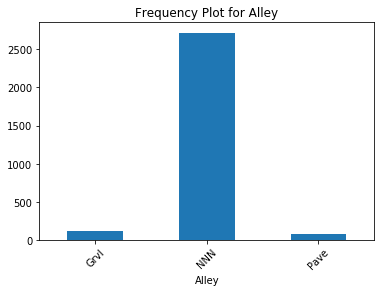

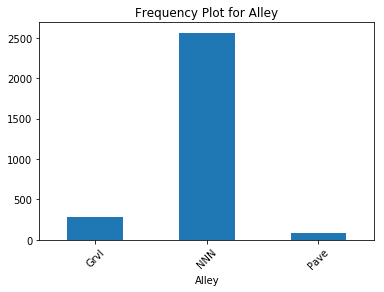

Grvl


In [376]:
def outerLandScape():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    print("Initial Shape : ", df.shape)
    
    '''beyond_house = [ 'MSZoning','Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
                      'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'PavedDrive','SaleCondition','Fence', 'Alley']
    df_temp = df[beyond_house].copy()
    for c in beyond_house:
        df_temp = df_temp[df_temp[c].notna()]#.reset_index()
        print(c, df_temp.shape)'''
    #display.display(df_temp)
    
    beyond_house = ['Street', 'PavedDrive', 'Alley']
    
    def getAlley(MSZoning, Street, LotShape, LandContour, LotConfig, 
                 LandSlope, Neighborhood, Condition1, Condition2, BldgType, 
                 HouseStyle, PavedDrive, SaleCondition, Fence):
        #print(SaleCondition, Fence)
        '''display.display(df_temp [ (df_temp['MSZoning'] == MSZoning ) &
                            (df_temp['Street'] == Street ) &
                            (df_temp['LotShape'] == LotShape) &
                            (df_temp['LandContour'] == LandContour) &
                            (df_temp['LotConfig'] == LotConfig) &
                            (df_temp['LandSlope'] == LandSlope) &
                            (df_temp['Neighborhood'] == Neighborhood) &
                            (df_temp['Condition1'] == Condition1) & 
                            (df_temp['Condition2'] == Condition2) & 
                            (df_temp['BldgType'] == BldgType) & 
                            (df_temp['HouseStyle'] == HouseStyle) & 
                            (df_temp['PavedDrive'] == PavedDrive) &
                            (df_temp['SaleCondition'] == SaleCondition) &
                            (df_temp['Fence'] == Fence)
        ][beyond_house])'''
        try:
            '''alley =  df_temp [    (df_temp['MSZoning'] == MSZoning ) &
                            (df_temp['Street'] == Street ) &
                            (df_temp['LotShape'] == LotShape) &
                            (df_temp['LandContour'] == LandContour) &
                            (df_temp['LotConfig'] == LotConfig) &
                            (df_temp['LandSlope'] == LandSlope) &
                            (df_temp['Neighborhood'] == Neighborhood) &
                            (df_temp['Condition1'] == Condition1) & 
                            (df_temp['Condition2'] == Condition2) & 
                            (df_temp['BldgType'] == BldgType) & 
                            (df_temp['HouseStyle'] == HouseStyle) & 
                            (df_temp['PavedDrive'] == PavedDrive) &
                            (df_temp['SaleCondition'] == SaleCondition) &
                            (df_temp['Fence'] == Fence)
                            #(df_temp['Alley'] == Alley)
                        ]['Alley'].tolist()[0]
            alley =  df [    (df['MSZoning'] == MSZoning ) &
                            (df['Street'] == Street ) &
                            (df['LotShape'] == LotShape) &
                            (df['LandContour'] == LandContour) &
                            (df['LotConfig'] == LotConfig) &
                            (df['LandSlope'] == LandSlope) &
                            (df['Neighborhood'] == Neighborhood) &
                            (df['Condition1'] == Condition1) & 
                            (df['Condition2'] == Condition2) & 
                            (df['BldgType'] == BldgType) & 
                            (df['HouseStyle'] == HouseStyle) & 
                            (df['PavedDrive'] == PavedDrive) &
                            (df['SaleCondition'] == SaleCondition) &
                            (df['Fence'] == Fence)
                            #(df['Alley'] == Alley)
                        ]['Alley'].tolist()[0]'''
            alley = df[
                (df['Street'] == Street ) &
                (df['PavedDrive'] == PavedDrive) 
            ]['Alley'].tolist()[0]
        except:
            alley = 'NA'
        
        return alley
        
    
    df['Alley'] = df.Alley.fillna("NNN")
    df[['Alley','SalePrice']].fillna(0).\
        groupby(by='Alley').agg('count').\
        plot.bar(legend=None, title="Frequency Plot for "+'Alley')
    plt.xticks(rotation=45)
    plt.show()
        
    df['Alley'] = df.apply( lambda x: getAlley (x['MSZoning']
                                                ,x['Street']
                                                ,x['LotShape'] 
                                                ,x['LandContour'] 
                                                ,x['LotConfig']
                                                ,x['LandSlope'] 
                                                ,x['Neighborhood']
                                                ,x['Condition1']
                                                ,x['Condition2']
                                                ,x['BldgType']
                                                ,x['HouseStyle']
                                                ,x['PavedDrive']
                                                ,x['SaleCondition']
                                                ,x['Fence']
                                                #,x['Alley'] 
                                               ) if x['Alley'] == "NNN" else x['Alley']
        ,axis=1)
    df[['Alley','SalePrice']].fillna(0).\
        groupby(by='Alley').agg('count').\
        plot.bar(legend=None, title="Frequency Plot for "+'Alley')
    plt.xticks(rotation=45)
    plt.show()
    
    print(getAlley('RM','Pave','Reg','Bnk','Inside','Gtl','IDOTRR','Norm','Norm','1Fam','1.5Unf','N','Normal','GdPrv'))
outerLandScape()

In [ ]:
def alleyWrangle():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    
    df[['Street','Alley','PavedDrive']]
alleyWrangle()

In [407]:
def exterior1stWrangle():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    df_temp = df[['Exterior1st','Neighborhood','Id']].groupby(['Neighborhood','Exterior1st']).agg('count').reset_index()
    df_temp_2 = df_temp.groupby('Neighborhood').agg('max').reset_index()[['Neighborhood','Exterior1st']]
    
    
    df_dict = dict([tuple(x) for x in df_temp_2.values])
    #df_dict = dict([tuple(x) for x in df[['Neighborhood', 'Exterior1st', 'Exterior2nd','ExterCond','ExterQual']]])
    print(df_dict['Edwards'])
    
    display.display(df[['Exterior1st', 'Exterior2nd','Neighborhood']][df.Exterior1st.isna()])
    display.display(df[['Exterior1st', 'Exterior2nd']][df.Exterior2nd.isna()])
    df['Exterior1st'] = df['Exterior1st'].fillna("NNN")
    df['Exterior1st'] = df.apply(lambda x: df_dict[x['Neighborhood']] if x['Exterior1st'] == "NNN" else x['Exterior1st'],
                                axis=1)
    
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df.Exterior1st)
    display.display(df[df.index.isin([2151])][['Exterior1st', 'Exterior2nd','Neighborhood']])
    
exterior1stWrangle()

WdShing


,Exterior1st,Exterior2nd,Neighborhood
2151,NaN,NaN,Edwards


,Exterior1st,Exterior2nd
2151,NaN,NaN


,Exterior1st,Exterior2nd,Neighborhood
2151,WdShing,WdShing,Edwards


##### it is observed that many of the houses have Exterior1st and Exterior2nd same values per neighborhood. Therefore, we will create a matrix of neighborhood and Exterior1st. We will first populate Exterior1st from neighborhood value and then we will populate Exterior2nd from Exterior1st.

In [229]:
def bsmtCheck():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True)
    #print(df.shape)
    
    bsmt_columns = [c for c in list(df) if 'Bsmt' in c]
    
    print("Shape of TotalBsmtSF = 0 : ", df[df.TotalBsmtSF == 0].shape)
    print("Shape of TotalBsmtSF is naN ", df[df.TotalBsmtSF.isna()].shape)
    
    for c in bsmt_columns:
        display.display(c, df[df[c].isna()][bsmt_columns])
    
bsmtCheck()
    

Shape of TotalBsmtSF = 0 :  (78, 81)
Shape of TotalBsmtSF is naN  (1, 81)


'BsmtCond'

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
39,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
90,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
102,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
156,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
182,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
259,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
342,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
362,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
371,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0


'BsmtExposure'

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
39,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
90,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
102,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
156,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
182,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
259,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
342,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
362,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
371,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0


'BsmtFinSF1'

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'BsmtFinSF2'

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'BsmtFinType1'

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
39,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
90,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
102,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
156,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
182,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
259,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
342,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
362,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
371,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0


'BsmtFinType2'

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
39,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
90,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
102,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
156,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
182,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
259,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
332,TA,No,1124.0,479.0,GLQ,NaN,1.0,0.0,Gd,1603.0,3206.0
342,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
362,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0


'BsmtFullBath'

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
728,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0


'BsmtHalfBath'

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
728,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0


'BsmtQual'

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
39,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
90,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
102,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
156,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
182,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
259,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
342,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
362,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
371,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0


'BsmtUnfSF'

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'TotalBsmtSF'

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [274]:
def BsmtCondCheck():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True, ignore_index=True)
    #print(df.shape)
    
    bsmt_columns = [c for c in list(df) if 'Bsmt' in c]
    
    print("Shape of TotalBsmtSF = 0 : ", df[df.TotalBsmtSF == 0].shape)
    print("Shape of TotalBsmtSF is naN ", df[df.TotalBsmtSF.isna()].shape)
    
    #for c in bsmt_columns:
    print(df[df.TotalBsmtSF > 0]['BsmtCond'].mode())
    display.display('BsmtCond', df[(df['BsmtCond'].isna()) & (df.TotalBsmtSF > 0)][bsmt_columns])
    
    bsmt_df =df.groupby(['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual','BsmtCond']).\
                    agg('count').reset_index() [['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']]
    bsmt_tuple = [tuple(x) for x in bsmt_df.values]
    
    
    def getBsmtCond(BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual):
        for t in bsmt_tuple:
            if t[0] == BsmtExposure:
                if t[1] == BsmtFinType1:
                    if t[2] == BsmtFinType2:
                        if t[3] == BsmtQual:
                            return t[4]
    
    print(getBsmtCond('No', 'Rec', 'Unf', 'TA'))  #Fa
    #print(getBsmtCond('Mn', 'GLQ', 'Rec', 'Gd'))  #??

    df['BsmtCond'] = df['BsmtCond'].fillna("NNN")
    df['BsmtCond'] = df.apply(lambda x: getBsmtCond(x['BsmtExposure'], 
                                                    x['BsmtFinType1'],
                                                    x['BsmtFinType2'],
                                                    x['BsmtQual']
                                                   ) if x['BsmtCond'] == 'NNN' else x['BsmtCond']
                             ,axis=1)
    
    display.display(df[df.index.isin([2040,2185,2524])][bsmt_columns])
    
BsmtCondCheck()


Shape of TotalBsmtSF = 0 :  (78, 81)
Shape of TotalBsmtSF is naN  (1, 81)
0    TA
dtype: object


'BsmtCond'

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2040,NaN,Mn,1044.0,382.0,GLQ,Rec,1.0,0.0,Gd,0.0,1426.0
2185,NaN,No,1033.0,0.0,BLQ,Unf,0.0,1.0,TA,94.0,1127.0
2524,NaN,Av,755.0,0.0,ALQ,Unf,0.0,0.0,TA,240.0,995.0


Fa


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2040,TA,Mn,1044.0,382.0,GLQ,Rec,1.0,0.0,Gd,0.0,1426.0
2185,Fa,No,1033.0,0.0,BLQ,Unf,0.0,1.0,TA,94.0,1127.0
2524,Gd,Av,755.0,0.0,ALQ,Unf,0.0,0.0,TA,240.0,995.0


* Alley: I wish we could split the "NotAvailable" to Grvl or Pave.
* TotalBsmtSF should be 0 if it is missing.
* BsmtQual = BsmtCond = BsmtExposure = BsmtFinType1 = BsmtFinType2 = "NA"; when TotalBsmtSF = 0 
* similarly, BsmtFinSF1 = BsmtFinSF2 = BsmtFullBath = BsmtHalfBath = BsmtUnfSF = 0 when TotalBsmtSF = 0
* BsmtQual = BsmtCond = BsmtExposure = BsmtFinType1 = BsmtFinType2 will be populated based on the those pattern present when TotalBsmtSF > 0
* Electrical, At timber, missing entry will be filled with 'SBrkr'

##### GrLivArea

In [ ]:
def GrLivAreaWrangling():
    
GrLivAreaWrangling()